# 2. 비지도학습

## 데이터 전처리

### 환경설정

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from prince import FAMD
from sklearn.cluster import DBSCAN
import umap.umap_ as umap
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

### 데이터 샘플링

In [ ]:
df = pd.read_csv('/content/df_mapping.csv')

identity = ['TransactionDT', 'recipient', 'DeviceInfo', 'region', 'receiver_bank','receiver_account', 'ip_address', 'app_version']
categories_col = ['voice_match', 'is_new_account_for_user', 'is_nighttime', 'is_new_device', 'vpn', 'payment_method', 'intent', 'authentication', 'rooting']
numerics_col = ['TransactionAmt', 'hour', 'avg_amount_to_bank', 'recent_transaction_gap'] #float32

In [ ]:
df_cleansing = df.drop(columns = identity, axis=1)
df_cleansing.drop(columns = 'transaction_time', axis=1, inplace=True)

In [ ]:
sampled_df = df_cleansing.sample(frac=0.1, random_state=42)

### 재현성 설정

In [ ]:
def seed_everything(seed=42):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.mamual_seed_all(seed)
  seed_everything()

# device 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### 전처리 및 분할

In [ ]:
X = sampled_df.astype(np.float32).values # float32 타입의 array로 변환

# 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 학습/검증 분할
X_train, X_val = train_test_split(X_scaled, test_size=0.1, random_state=42, shuffle=True)

## 1-1. Isolation Forest

In [ ]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
# 이상여부 예측
iso_scores = -iso.fit_predict(X_scaled)

In [ ]:
# -1 해주는 이유: decision_function은 이상할 수록 작은 값이므로 부호 반전을 위해 -1 곱해줌
sampled_df['if_anomaly_score'] = iso.decision_function(X_scaled) * -1
# anomaly_flag 설정(1이 정상, -1이 이상인데 -> 부호 반전을 통해 1이 anomaly_flag로 변환)
sampled_df['if_anomaly_flag'] = (iso_scores == 1).astype(int)

In [ ]:
sampled_df.head(1)

,TransactionAmt,hour,avg_amount_to_bank,amount_ratio_to_bank_avg,recent_transaction_gap,voice_match,is_new_account_for_user,is_nighttime,is_new_device,vpn,rooting,payment_method_P02,payment_method_P03,payment_method_P04,payment_method_P05,payment_method_P06,intent_T02,intent_T03,intent_T04,intent_T05,authentication_A02,authentication_A03,authentication_A04,authentication_A05,authentication_A06,if_anomaly_score,if_anomaly_flag
470624,724000.0,20,426528,1.697427,26.15878,0,0,0,0,1,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,-0.005678,0


## 1-2. Autoencoder

In [ ]:
'''
Autoencoder는 입력 데이터를 압축(encoding)하고 다시 원래대로 복원(decoding)하는 방식으로 학습하는 신경망
이 방식을 통해서 데이터의 이상값을 감지함
(왜냐하면 정상값은 잘 복원되는데 이상거래는 학습되지 않은 패턴이라 복원 오류(MSE)가 커짐)
'''
class Autoencoder(nn.Module):
  def __init__(self, input_dim):
    super(Autoencoder, self).__init__()

    # 1. encoder: 데이터를 저차원(latent vector)으로 압축하는 단계
    self.encoder = nn.Sequential(
        nn.Linear(input_dim, 16), # input -> 16차원 압축
        nn.ReLU(),
        nn.Linear(16, 8) # 16 -> 8차원 latent vector
    )

    # 2. decoder: 복원 단계
    self.decoder = nn.Sequential(
        nn.Linear(8, 16), # 8차원 latent -> 16차원
        nn.ReLU(),
        nn.Linear(16, input_dim) # 16차원으로 복구
    )

  def forward(self, x):
    '''
    학습 및 예측시 forward 메소드 호출
    input 데이터를 encoding -> decoding 단계로 처리,
    x: 입력 데이터(batch_size, input_dim)
    return값: 복원된 데이터
    '''
    encoded = self.encoder(x) # 압축
    decoded = self.decoder(encoded) # 복원
    return decoded

In [ ]:
# X_train, X_val -> pytorch 텐서로 변환 -> device에 올리기
train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)

# ae 모델 initialization (input dim은 train set 기준)
model = Autoencoder(input_dim=train_tensor.shape[1]).to(device)

# loss 함수 정의: MSE(평균 제곱 오차) -> 재구성 오류 측정
criterion = nn.MSELoss()

# 최적화: Adam -> 가중치 업데이트
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# 루프돌면서 모델 학습, 가중치 업데이트, 오버피팅 감지
for epoch in range(50):
  model.train()
  optimizer.zero_grad() # 이전 에폭에서의 gradient initialization(안해주면 계속 쌓인다)
  output = model(train_tensor) # ae통해 input 재구성
  loss = criterion(output, train_tensor) # 실제 input과 재구성 결과의 차이를 손실로 계산
  loss.backward() # loss func에 따라서 역전파
  optimizer.step() # 가중치 업뎃

# 매 10 에폭마다 val loss 확인(오버피팅 감지)
  if epoch % 10 == 0:
    model.eval() # 모델을 평가모드로 전환
    val_out = model(val_tensor) # val 데이터 재구성
    val_loss = criterion(val_out, val_tensor).item() # val loss 계산
    print(f'Epoch {epoch} - Train Loss: {loss.item():.4f} - Val Loss: {val_loss:.4f}')

Epoch 0 - Train Loss: 1.0331 - Val Loss: 0.9824
Epoch 10 - Train Loss: 1.0174 - Val Loss: 0.9680
Epoch 20 - Train Loss: 1.0048 - Val Loss: 0.9564
Epoch 30 - Train Loss: 0.9925 - Val Loss: 0.9446
Epoch 40 - Train Loss: 0.9783 - Val Loss: 0.9307


- train loss: 모델이 학습 데이터 구조를 잘 복원하는지 측정
- val loss: 과적합 여부 확인(train만 잘 맞추는 경우인지 확인)
- 위 경우 에폭마다 train-val loss가 비슷: 오버피팅이 거의 없다(학습이 안정적이고 일반화 성능이 양호)


```
재구성 손실이
- 1 ~ 2: 양호한 수준
- 5 이상: 언더피팅 가능성(input feature를 잘 복원하지 못하는 중)
- 0.1 이하: 오버피팅 가능성(과도한 복원 -> 이상탐지 감도가 약해질 수 있다)
```



In [ ]:
model.eval()

# 전체 데이터셋을 텐서로 변환 -> 디바이스에 올리기
full_tensor = torch.tensor(X_scaled, dtype = torch.float32).to(device)

# ae로 전체 데이터 재구성 실행
recon = model(full_tensor)

# 재구성 오차(mse)를 각 샘플마다 계산
# 이상 거래일 수록 원본과 재구성 차이가 크다 -> score도 커진다
mse = torch.mean((full_tensor - recon)**2, dim = 1).cpu().detach().numpy() # 이상탐지 score: 재구성 실패 정도, 높을 수록 이상거래일 가능성이 높다.

In [ ]:
print("MSE 최소값:", np.min(mse))
print("MSE 최대값:", np.max(mse))
print("MSE 평균:", np.mean(mse))
print("MSE 상위 5% 기준:", np.percentile(mse, 95))

MSE 최소값: 0.33151886
MSE 최대값: 2149.8242
MSE 평균: 0.9563057
MSE 상위 5% 기준: 1.164446


In [ ]:
diff = (full_tensor - recon).cpu().detach().numpy()
print("평균 차이:", np.mean(np.abs(diff)))

평균 차이: 0.7721894


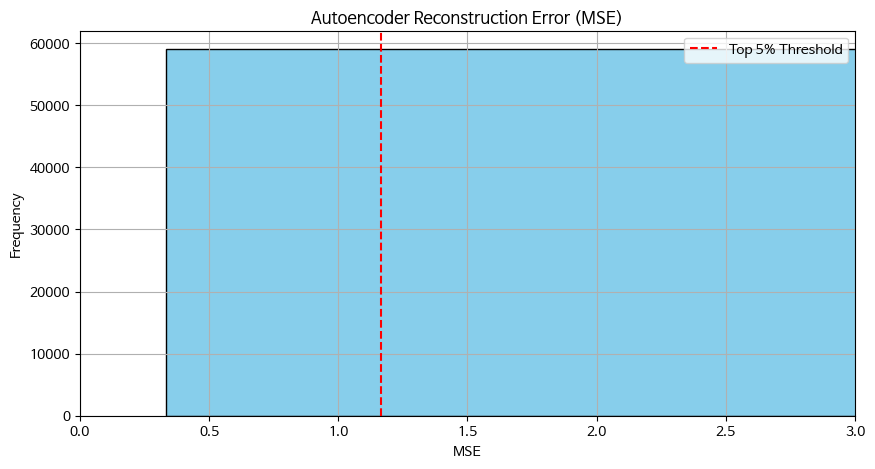

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

# MSE 분포 히스토그램 (이상치로 인한 왜곡 방지 위해 xlim 조정)
plt.hist(mse, bins=50, color='skyblue', edgecolor='black')

# 상위 5% 기준선 표시
threshold_95 = np.percentile(mse, 95)
plt.axvline(threshold_95, color='red', linestyle='--', label='Top 5% Threshold')

# 시각적으로 보기 좋은 범위로 x축 제한 설정
plt.xlim(0, 3)

plt.title("Autoencoder Reconstruction Error (MSE)")
plt.xlabel("MSE")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# anomaly score -> 높은 값일 수록 anomaly하다고 판단
sampled_df['ae_anomaly_score'] = mse
sampled_df['ae_anomaly_flag'] = (sampled_df['ae_anomaly_score'] > np.percentile(mse, 95)).astype(int)

In [ ]:
sampled_df[['ae_anomaly_score', 'ae_anomaly_flag']].describe()

,ae_anomaly_score,ae_anomaly_flag
count,59054.000000,59054.000000
mean,0.956306,0.050005
std,8.852702,0.217957
min,0.331519,0.000000
25%,0.789025,0.000000
50%,0.896141,0.000000
75%,0.987437,0.000000
max,2149.824219,1.000000


## 1-3. VAE(Variational Autoencoder)

In [ ]:
'''
VAE는 AE랑 다르게 잠재공간(latent space)을 확률 분포로 모델링.
더 일반화된 이상탐지 및 패턴 이해가 가능
'''
# 인코더 -> 분포 인코더 -> 디코더1 -> 디코더2 로 구현
class VAE(nn.Module):
  def __init__(self, input_dim):
    super().__init__()

    # encoder: input 데이터 -> 잠재 공간으로 변환
    self.fc1 = nn.Linear(input_dim, 16) # input -> 중간 차원
    self.fc21 = nn.Linear(16, 8) # 평균 벡터(mu)
    self.fc22 = nn.Linear(16, 8) # 로그 분산 벡터(logvar)

    # decoder: 잠재 공간을 원래 input 차원으로 복원
    self.fc3 = nn.Linear(8, 16)
    self.fc4 = nn.Linear(16, input_dim)

  def encode(self, x):
    # 인코더 실행: 입력 -> 평균/분산 값 추출
    h1 = torch.relu(self.fc1(x))
    return self.fc21(h1), self.fc22(h1) # 평균, 로그분산 출력

  def reparam(self, mu, logvar):
    # reparameterization: 랜덤성을 도입해 샘플링 가능한 latent 벡터 생성
    std = torch.exp(0.5 * logvar)
    eps = torch.rand_like(std)
    return mu + eps * std # z = mu + eps*sig

  def decode(self, z):
    # 디코더 실행: 복원
    h3 = torch.relu(self.fc3(z))
    return self.fc4(h3)

  def forward(self, x):
    # 전체 VAE 순전파 구조
    mu, logvar = self.encode(x)
    z = self.reparam(mu, logvar)
    return self.decode(z), mu, logvar

In [ ]:
# Loss function
# Reconstruction Loss: 입력을 얼마나 잘 복원했는가(MSE)
# KL Divergence Loss: latent 분포가 얼마나 정규분포와 가까운가

def vae_loss(x, recon, mu, logvar):
  BCE = nn.functional.mse_loss(recon, x, reduction = 'mean') # 재구성 오차
  KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp()) # 정규분포와의 차이
  return BCE + KLD # 두 로스의 합이 최종 로스

In [ ]:
# model train
vae = VAE(input_dim = X_train.shape[1]).to(device)
optimizer = optim.Adam(vae.parameters(), lr = 0.001)
X_tensor = torch.tensor(X_train, dtype = torch.float32).to(device)

In [ ]:
# train loop
for epoch in range(50):
  vae.train()
  optimizer.zero_grad()

  recon, mu, logvar = vae(X_tensor) # 입력 -> 복원+latent 분포 추출
  loss = vae_loss(X_tensor, recon, mu, logvar) # 로스 계산
  loss.backward()
  optimizer.step() # 파라미터 업데이트

In [ ]:
# MSE 계산
vae.eval()
full_tensor = torch.tensor(X_scaled, dtype = torch.float32).to(device)

# 전체 input 재구성 실행
recon, mu, logvar = vae(full_tensor)

# 재구성 실패 정도(MSE)를 anomaly score로 활용
vae_mse = torch.mean((recon - full_tensor)**2, dim = 1).cpu().detach().numpy()

# Latent Vector 추출 -> 추후 클러스터링에 사용
latent_z = vae.reparam(mu, logvar).cpu().detach().numpy()

# anomaly score 및 flag 저장(top 5% -> 이상 거래 탐지)
sampled_df['vae_anomaly_score'] = vae_mse
sampled_df['vae_anomaly_flag'] = (sampled_df['vae_anomaly_score'] > np.percentile(vae_mse, 95)).astype(int)

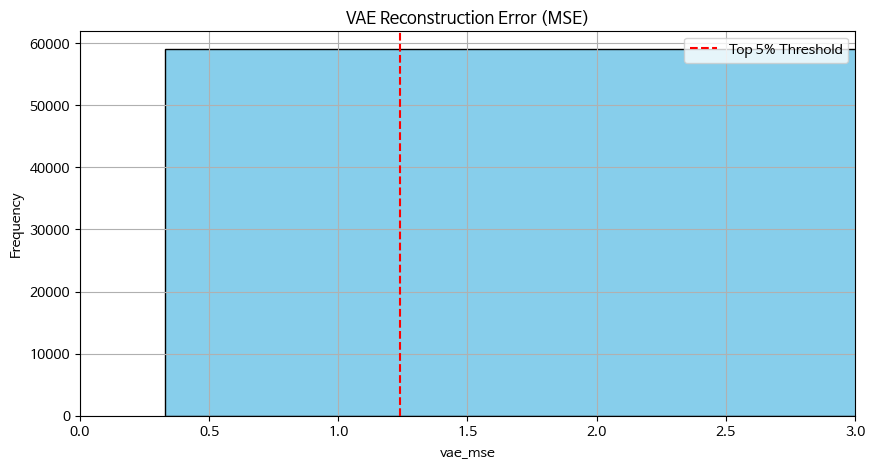

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

# MSE 분포 히스토그램 (이상치로 인한 왜곡 방지 위해 xlim 조정)
plt.hist(vae_mse, bins=50, color='skyblue', edgecolor='black')

# 상위 5% 기준선 표시
threshold_95 = np.percentile(vae_mse, 95)
plt.axvline(threshold_95, color='red', linestyle='--', label='Top 5% Threshold')

# 시각적으로 보기 좋은 범위로 x축 제한 설정
plt.xlim(0, 3)

plt.title("VAE Reconstruction Error (MSE)")
plt.xlabel("vae_mse")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

## 1-4. Hybrid Risk Score 계산

In [ ]:
# anomaly score를 정규화해서 비교 -> 백분위(rank-based)로 정규화
sampled_df['if_score_norm'] = sampled_df['if_anomaly_score'].rank(pct=True)
sampled_df['ae_score_norm'] = sampled_df['ae_anomaly_score'].rank(pct=True)
sampled_df['vae_score_norm'] = sampled_df['vae_anomaly_score'].rank(pct=True)

# 가중치 설정
alpha_if, alpha_ae, alpha_vae = 0.33, 0.33, 0.34

# Hybrid risk score: 3개 모델의 anomaly score 평균(가중합 방식)
sampled_df['hr_score'] = (alpha_if * sampled_df['if_score_norm'] + alpha_ae * sampled_df['ae_score_norm'] + alpha_vae * sampled_df['vae_score_norm'])

In [ ]:
threshold = np.percentile(sampled_df['hr_score'], 95)
sampled_df['hr_anomaly_flag'] = (sampled_df['hr_score'] > threshold).astype(int)

In [ ]:
sampled_df

,TransactionAmt,hour,avg_amount_to_bank,amount_ratio_to_bank_avg,recent_transaction_gap,voice_match,is_new_account_for_user,is_nighttime,is_new_device,vpn,rooting,payment_method_P02,payment_method_P03,payment_method_P04,payment_method_P05,payment_method_P06,intent_T02,intent_T03,intent_T04,intent_T05,authentication_A02,authentication_A03,authentication_A04,authentication_A05,authentication_A06,if_anomaly_score,if_anomaly_flag,ae_anomaly_score,ae_anomaly_flag,vae_anomaly_score,vae_anomaly_flag,if_score_norm,ae_score_norm,vae_score_norm,hr_score,hr_anomaly_flag
470624,724000.0,20,426528,1.697427,26.158780,0,0,0,0,1,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,-0.005678,0,1.192334,1,1.160221,0,0.923409,0.956142,0.907017,0.928638,1
565820,108500.0,1,390611,0.277770,148.281147,0,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,-0.052330,0,0.892495,0,0.972821,0,0.348037,0.489941,0.569817,0.470271,0
284083,47950.0,19,78538,0.610532,97.661782,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,-0.057959,0,0.874214,0,0.952483,0,0.290412,0.437650,0.517391,0.416174,0
239689,100599.0,6,112054,0.897773,37.420775,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,-0.101115,0,0.620707,0,0.557901,0,0.028618,0.045264,0.017780,0.030426,0
281855,107950.0,15,227421,0.474670,24.694017,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-0.105138,0,0.550920,0,0.525344,0,0.020253,0.017171,0.009805,0.015683,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381930,775660.0,19,121440,6.387187,16.584275,0,1,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0.004485,1,1.319700,1,1.372651,1,0.964185,0.971281,0.971162,0.968899,1
229309,20241.0,4,289722,0.069864,73.702943,1,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,-0.046668,0,0.674388,0,0.918479,0,0.423206,0.081552,0.429675,0.312660,0
192169,49000.0,2,325133,0.150708,55.382868,1,0,1,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,-0.035576,0,1.006246,0,1.204639,0,0.611305,0.792427,0.936126,0.781515,0
528625,82950.0,15,202655,0.409316,50.498418,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,-0.072825,0,0.690738,0,0.704449,0,0.149456,0.097369,0.083297,0.109773,0
